## Decoding in sensor space data using the Common Spatial Pattern (CSP)

We plan on using a CSP mapping scheme to identify which channels are most useful in deciding new/scrambled images. 

The code for the brain mapping is from the MNE documentation: https://martinos.org/mne/stable/auto_examples/decoding/plot_decoding_csp_space.html



In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams.update({'font.size': 12})


import mne 

path = "/Users/shateeshbhugwansing/Desktop/seniorprojecteeg/clean_data_sample/Ex10_Suj1_Run1-epo.fif"
epo_1 = mne.read_epochs(path, preload=True);

Reading /Users/shateeshbhugwansing/Desktop/seniorprojecteeg/clean_data_sample/Ex10_Suj1_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
280 matching events found
Created an SSP operator (subspace dimension = 1)
280 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [3]:
# Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#          Romain Trachel <romain.trachel@inria.fr>
#
# License: BSD (3-clause)

tmin, tmax = -0.2, 0.5
labels = epo_1.events[:, -1]
evoked = epo_1.average()


In [7]:
#### Creating a linear SVM

from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa

n_components = 4  # pick some components
svc = SVC(C=1, kernel='linear')
csp = CSP(n_components=n_components, norm_trace=False)

# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = []
epo_1_data = epo_1.get_data()

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epo_1_data[train_idx], y_train)
    X_test = csp.transform(epo_1_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))


Classification accuracy: 0.244643 / Chance level: 0.746429


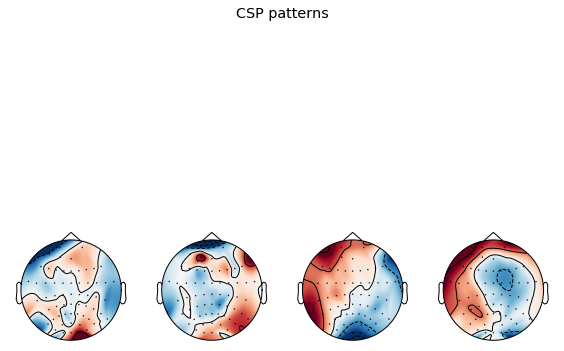

In [8]:
# Or use much more convenient scikit-learn cross_val_score function using
# a Pipeline
'''
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
clf = Pipeline([('CSP', csp), ('SVC', svc)])
scores = cross_val_score(clf, epo_1_data, labels, cv=cv, n_jobs=1)
print(scores.mean())  # should match results above

# And using reuglarized csp with Ledoit-Wolf estimator
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)
clf = Pipeline([('CSP', csp), ('SVC', svc)])
scores = cross_val_score(clf, epo_1_data, labels, cv=cv, n_jobs=1)
print(scores.mean())  # should get better results than above
'''

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epo_1_data, labels)
data = csp.patterns_
fig, axes = plt.subplots(1, 4)
for idx in range(4):
    mne.viz.plot_topomap(data[idx], evoked.info, axes=axes[idx], show=False)
fig.suptitle('CSP patterns')
fig.tight_layout()

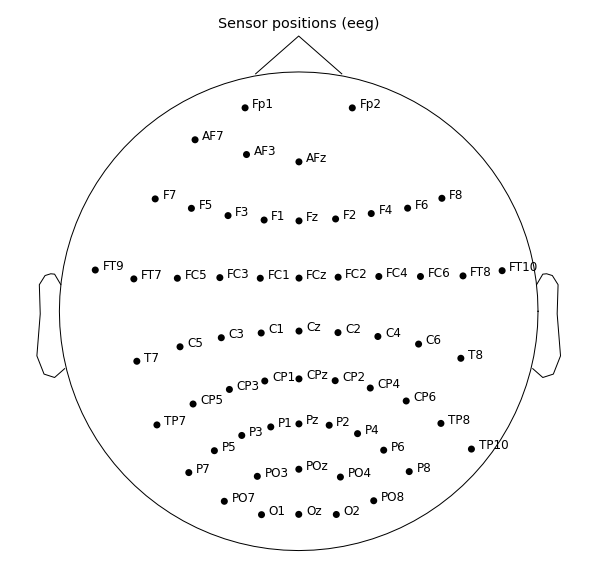

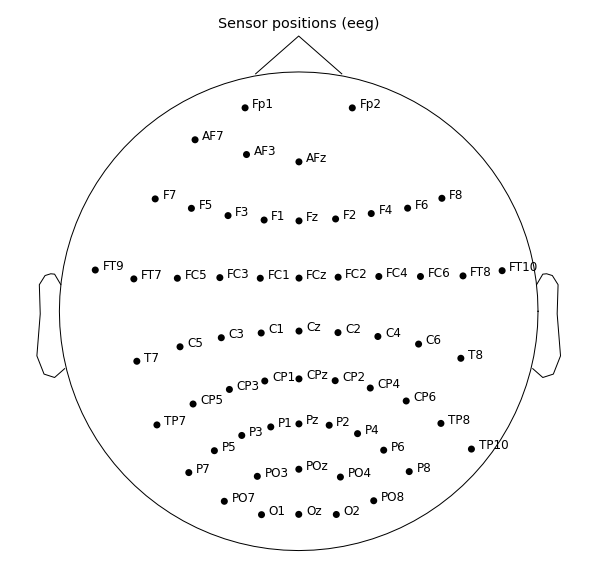

In [9]:
epo_1.plot_sensors(show_names=True)